In [120]:
from sklearn.feature_extraction.text import TfidfVectorizer
import nltk 
nltk.download('stopwords')  
from nltk.corpus import stopwords
## Table & Visualization Libraries
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import scipy
import pickle
import json

## Prediction Libraries
from sklearn.metrics import classification_report, confusion_matrix, \
accuracy_score, plot_confusion_matrix, auc, roc_curve

## Cross-Validation Libraries
from sklearn.model_selection import train_test_split, cross_val_score, StratifiedKFold
from xgboost import XGBClassifier

## Model Libraries
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB, BernoulliNB, MultinomialNB
from sklearn.svm import SVC

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\bahyh\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [121]:
rejected_paragraphs = pd.read_csv("rejected_paragraphs.csv")
rejected_paragraphs['label'] = 1

In [122]:
approved_paragraphs = pd.read_csv("approved_paragraphs.csv")
approved_paragraphs['label'] = 0

In [123]:
paragraphs = pd.concat([approved_paragraphs, rejected_paragraphs])

In [124]:
paragraphs

,website,paragraph,label
0,http://asiatrip.id/,\nusername\n\n\n\npassword\n\n\n\n\n\n\nforget...,0
1,https://www.blooming-lotus-yoga.com,there has been a critical error on your websit...,0
2,https://greensejahterafoundation.com/,yayasan green sejahtera mengajak seluruh masya...,0
3,http://www.matair.co.id,\n\n\n\n\n\n\n\n\n\n\n\n\n\n\npt. matair terra...,0
4,https://www.simplymii.com/,\n\n\n\nlog in\n\n\nen / \n ...,0
...,...,...,...
72,http://www.xxx.com,you have tried to access a web page which is i...,1
73,http://www.asiabuana.com,\n\t\t\t\t\t\t\ttidak ada produk\n\t\t\t\t\t\t...,1
74,http://go-modis.com/,NaN,1
75,http://www.japanchi.com,NaN,1


In [125]:
X = paragraphs.iloc[:, 1].values
y = paragraphs.iloc[:, 2].values

In [126]:
processed_paragraphs = []
 
for paragraph in range(0, len(X)):  
    # Remove all the special characters
    processed_paragraph = re.sub(r'\W', ' ', str(X[paragraph]))
 
    # remove all single characters
    processed_paragraph = re.sub(r'\s+[a-zA-Z]\s+', ' ', processed_paragraph)
 
    # Remove single characters from the start
    processed_paragraph = re.sub(r'\^[a-zA-Z]\s+', ' ', processed_paragraph) 
 
    # Substituting multiple spaces with single space
    processed_paragraph= re.sub(r'\s+', ' ', processed_paragraph, flags=re.I)
 
    # Removing prefixed 'b'
    processed_paragraph = re.sub(r'^b\s+', '', processed_paragraph)
 
    # Converting to Lowercase
    processed_paragraph = processed_paragraph.lower()
 
    processed_paragraphs.append(processed_paragraph)

In [127]:
tfidfconverter = TfidfVectorizer(max_features=2000, stop_words=stopwords.words('indonesian'))  
X = tfidfconverter.fit_transform(processed_paragraphs).toarray()

c:\users\bahyh\appdata\local\programs\python\python37\lib\site-packages\sklearn\feature_extraction\text.py:385: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['baiknya', 'berkali', 'kali', 'kurangnya', 'mata', 'olah', 'sekurang', 'setidak', 'tama', 'tidaknya'] not in stop_words.
  'stop_words.' % sorted(inconsistent))
c:\users\bahyh\appdata\local\programs\python\python37\lib\site-packages\gevent\hub.py:154: UserWarning: libuv only supports millisecond timer resolution; all times less will be set to 1 ms
  with loop.timer(seconds, ref=ref) as t:


In [160]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)

In [161]:
## Gaussian Naive Bayes has a good ability to predict REJECTED websites, but it is hard to got a low FP Rate with this model.
## While XGBoost provides more reliable model with low FP rate and enough TP rate
## Though, it goes back to the business decision which rate is more important

model_choice = GaussianNB()
# model_choice = BernoulliNB()
# model_choice = MultinomialNB()
# model_choice = XGBClassifier(**params)

In [162]:
clf = model_choice
clf = clf.fit(X_train, y_train)

c:\users\bahyh\appdata\local\programs\python\python37\lib\site-packages\gevent\hub.py:154: UserWarning: libuv only supports millisecond timer resolution; all times less will be set to 1 ms
  with loop.timer(seconds, ref=ref) as t:


In [163]:
## Using the default threshold == 0.5
y_pred = clf.predict(X_test)

c:\users\bahyh\appdata\local\programs\python\python37\lib\site-packages\gevent\hub.py:154: UserWarning: libuv only supports millisecond timer resolution; all times less will be set to 1 ms
  with loop.timer(seconds, ref=ref) as t:


In [164]:
y_pred_proba = clf.predict_proba(X_test)

c:\users\bahyh\appdata\local\programs\python\python37\lib\site-packages\gevent\hub.py:154: UserWarning: libuv only supports millisecond timer resolution; all times less will be set to 1 ms
  with loop.timer(seconds, ref=ref) as t:


In [165]:
np.round(accuracy_score(y_test, y_pred), 2)

0.86

In [166]:
pd.Series(y_train).value_counts(), pd.Series(y_test).value_counts()

(0    142
 1     53
 dtype: int64,
 0    73
 1    24
 dtype: int64)

In [167]:
## Confusion matrix with best TPR threshold
tn, fp, fn, tp = confusion_matrix(y_test, y_pred).ravel()

In [168]:
tpr, fpr = np.round((tp/(tp+fn), fp/(fp+tn)), 3)
## TPR = Dari semua REJECTED merchant berapa % yang berhasil kereject, 
## FPR = Dari semua APPROVED berapa % yang kita salah tebak sebagai REJECTED
## This rate applies to a default threshold of 0.5
tpr, fpr

(0.75, 0.11)

In [169]:
tn, fp, fn, tp

(65, 8, 6, 18)

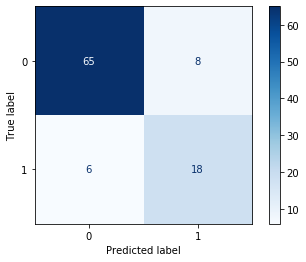

c:\users\bahyh\appdata\local\programs\python\python37\lib\site-packages\gevent\hub.py:154: UserWarning: libuv only supports millisecond timer resolution; all times less will be set to 1 ms
  with loop.timer(seconds, ref=ref) as t:


In [170]:
## This matrix visualization is based on 0.5 threshold
plot_confusion_matrix(clf, X_test, y_test, cmap=plt.cm.Blues)
plt.show()

In [171]:
fpr, tpr, thresholds = roc_curve(y_test, y_pred_proba[:,1])

In [172]:
auc_score = auc(fpr, tpr)

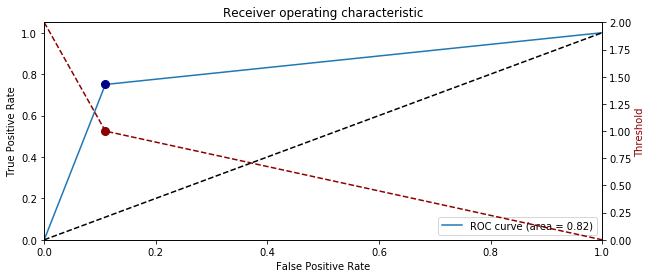

 -- Optimum Threshold -- 
        fpr   tpr     1-fpr        tf  thresholds
1  0.109589  0.75  0.890411 -0.140411         1.0


c:\users\bahyh\appdata\local\programs\python\python37\lib\site-packages\gevent\hub.py:154: UserWarning: libuv only supports millisecond timer resolution; all times less will be set to 1 ms
  with loop.timer(seconds, ref=ref) as t:


In [173]:
plt.figure(figsize=(10,4))
plt.plot(fpr, tpr, label='ROC curve (area = %0.2f)' % (auc_score))
plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic')
plt.legend(loc="lower right")

# find optimum thresholds
i = np.arange(len(tpr)) # index for df
roc = pd.DataFrame({'fpr' : pd.Series(fpr, index=i),'tpr' : pd.Series(tpr, index = i), '1-fpr' : pd.Series(1-fpr, index = i), 'tf' : pd.Series(tpr - (1-fpr), index = i).apply(lambda x: x), 'thresholds' : pd.Series(thresholds, index = i)})
df_thresh = roc.iloc[(roc.tf-0).abs().argsort()[:1]]

plt.plot(df_thresh['fpr'], df_thresh['tpr'], marker='o', markersize=8, color='darkblue')

# create the axis of thresholds (scores)
ax2 = plt.gca().twinx()
ax2.plot(fpr, thresholds, markeredgecolor='r',linestyle='dashed', color='darkred')
ax2.set_ylabel('Threshold',color='darkred')
ax2.set_ylim([thresholds[-1],thresholds[0]])
ax2.set_xlim([fpr[0],fpr[-1]])
ax2.plot(df_thresh['fpr'], df_thresh['thresholds'], marker='o', markersize=8, color='darkred')


plt.show()
print(" -- Optimum Threshold -- ")
print(df_thresh)

In [174]:
print("-- Best TPR Threshold -- ")
## Finding threshold where TPR > Optimum TPR but FPR stays below 15%
for i in range(len(fpr)):
#     if tpr[i] > 0.85 and fpr[i] < 0.20:
        print("TPR %s, FPR %s, Threshold %s" % (tpr[i], fpr[i], thresholds[i]))

-- Best TPR Threshold -- 
TPR 0.0, FPR 0.0, Threshold 2.0
TPR 0.75, FPR 0.1095890410958904, Threshold 1.0
TPR 1.0, FPR 1.0, Threshold 0.0


## Bootstrapped

In [175]:
accuracy_list = []
auc_list = []
for i in range(1000):
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=i)
    clf = model_choice
    clf = clf.fit(X_train, y_train)
    y_pred = clf.predict(X_test)
    y_pred_proba = clf.predict_proba(X_test)
    accuracy = accuracy_score(y_test, y_pred)
    fpr, tpr, thresholds = roc_curve(y_test, y_pred_proba[:,1])
    auc_score = auc(fpr, tpr)
    
    accuracy_list.append(accuracy)
    auc_list.append(auc_score)
    print("Iteration %s: AUC:%s, Accuracy:%s" % (i, auc_score, accuracy))

Iteration 0: AUC:0.7432692307692308, Accuracy:0.7835051546391752
Iteration 1: AUC:0.7808775731310943, Accuracy:0.8041237113402062
Iteration 2: AUC:0.706060606060606, Accuracy:0.7938144329896907
Iteration 3: AUC:0.7758333333333334, Accuracy:0.7835051546391752
Iteration 4: AUC:0.7440068493150686, Accuracy:0.8041237113402062
Iteration 5: AUC:0.8641251221896382, Accuracy:0.8762886597938144
Iteration 6: AUC:0.7826797385620915, Accuracy:0.8144329896907216
Iteration 7: AUC:0.7732804232804232, Accuracy:0.8041237113402062
Iteration 8: AUC:0.769047619047619, Accuracy:0.8144329896907216
Iteration 9: AUC:0.8107287449392713, Accuracy:0.8556701030927835
Iteration 10: AUC:0.8330687830687831, Accuracy:0.8247422680412371
Iteration 11: AUC:0.7817460317460317, Accuracy:0.7835051546391752
Iteration 12: AUC:0.7661375661375661, Accuracy:0.7938144329896907
Iteration 13: AUC:0.7540567951318458, Accuracy:0.7938144329896907
Iteration 14: AUC:0.7565005417118092, Accuracy:0.8041237113402062
Iteration 15: AUC:0.67

c:\users\bahyh\appdata\local\programs\python\python37\lib\site-packages\gevent\hub.py:154: UserWarning: libuv only supports millisecond timer resolution; all times less will be set to 1 ms
  with loop.timer(seconds, ref=ref) as t:


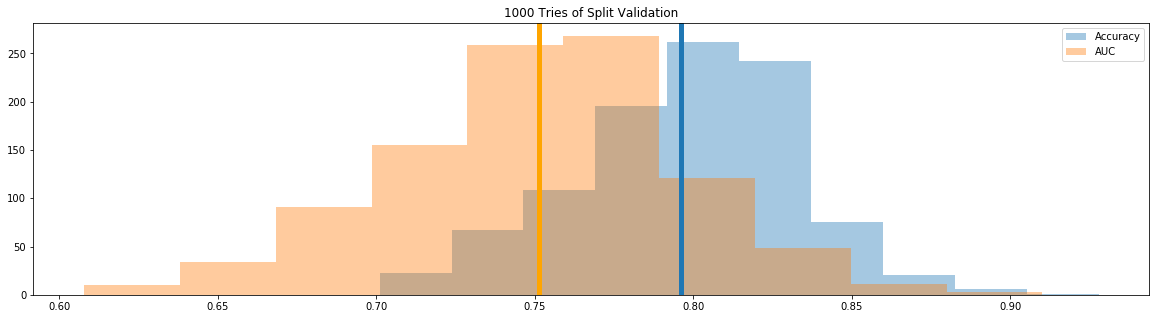

Accuracy mean: 0.80
AUC mean: 0.75


c:\users\bahyh\appdata\local\programs\python\python37\lib\site-packages\gevent\hub.py:154: UserWarning: libuv only supports millisecond timer resolution; all times less will be set to 1 ms
  with loop.timer(seconds, ref=ref) as t:


In [176]:
plt.figure(figsize=(20,5))
plt.title("1000 Tries of Split Validation")
sns.distplot(accuracy_list, bins=10, label = 'Accuracy', kde=False)
sns.distplot(auc_list, bins=10, label = 'AUC', kde=False)
plt.axvline(x=pd.Series(accuracy_list).mean(), lw=5)
plt.axvline(x=pd.Series(auc_list).mean(), lw=5, color='orange')
plt.legend()
plt.show()
print("Accuracy mean: %0.2f" % pd.Series(accuracy_list).mean())
print("AUC mean: %0.2f" % pd.Series(auc_list).mean())

## Model Comparison

In [177]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)

In [180]:
## Initiate models
models = []
models.append(('K-Nearest Neighbour', KNeighborsClassifier()))
models.append(('Decision Tree Classifier', DecisionTreeClassifier()))
models.append(('Gaussian Naive Bayes', GaussianNB()))
models.append(('Bernoulli Naive Bayes', BernoulliNB()))
models.append(('Multinomial Naive Bayes', MultinomialNB()))
models.append(('XGBoost Classifier', XGBClassifier()))

In [181]:
## Results
results = []
names = []
for name, model in models:
    kfold = StratifiedKFold(n_splits=5, random_state=42, shuffle=True)
    ## AUC Scoring
    cv_results = cross_val_score(model, X_train, y_train, cv=kfold, scoring='roc_auc')
    results.append(cv_results)
    names.append(name)
    print('%s: \nAUC Mean %f, STD %f\n'%(name, cv_results.mean(), cv_results.std()))

K-Nearest Neighbour: 
AUC Mean 0.644514, STD 0.108059

Decision Tree Classifier: 
AUC Mean 0.623117, STD 0.031458

Gaussian Naive Bayes: 
AUC Mean 0.696252, STD 0.090026

Bernoulli Naive Bayes: 
AUC Mean 0.747521, STD 0.054526

Multinomial Naive Bayes: 
AUC Mean 0.680862, STD 0.059946

XGBoost Classifier: 
AUC Mean 0.704400, STD 0.104179



c:\users\bahyh\appdata\local\programs\python\python37\lib\site-packages\gevent\hub.py:154: UserWarning: libuv only supports millisecond timer resolution; all times less will be set to 1 ms
  with loop.timer(seconds, ref=ref) as t:


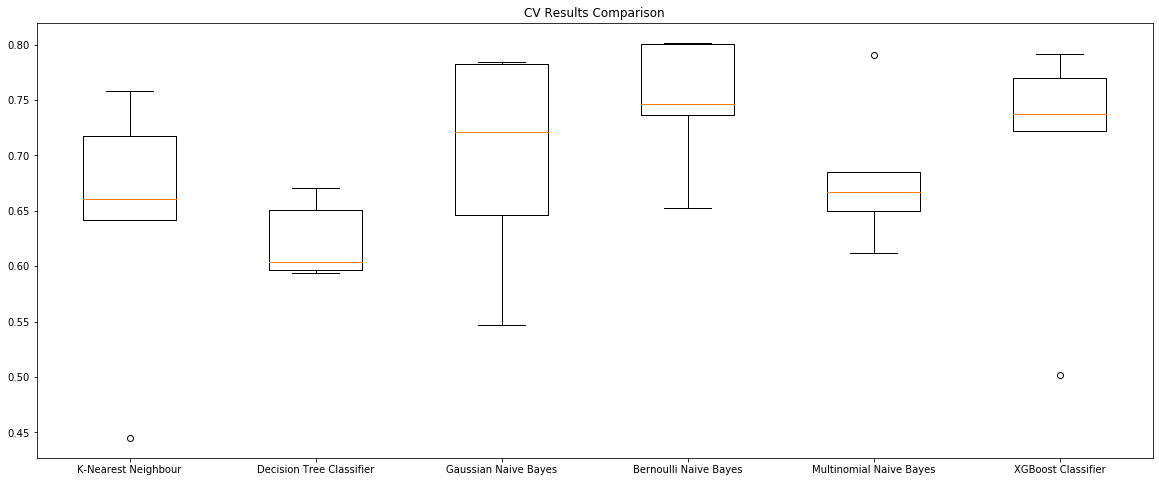

c:\users\bahyh\appdata\local\programs\python\python37\lib\site-packages\gevent\hub.py:154: UserWarning: libuv only supports millisecond timer resolution; all times less will be set to 1 ms
  with loop.timer(seconds, ref=ref) as t:


In [182]:
## Results Distribution
plt.figure(figsize=(20,8))
plt.boxplot(results, labels=names)
plt.title('CV Results Comparison')
plt.show()